# Wasserstein Pareto Frontier Experiment on LSAC Data Set


## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_Pandas_Case_Study

In [2]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from time import perf_counter

# Download the LSAT dataset and setup the required filepaths.
_DATA_ROOT = tempfile.mkdtemp(prefix='lsat-data')
_DATA_PATH = 'https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv'
_DATA_FILEPATH = os.path.join(_DATA_ROOT, 'bar_pass_prediction.csv')
data = urllib.request.urlopen(_DATA_PATH)
df = pd.read_csv(data)

# independnet variable features
X_features = ["gender","lsat","pass_bar","cluster","zfygpa","zgpa","fam_inc","age"]
# dependnet variable features
Y_features = ["gpa"]
# sensitive variable features
Z_features = ["race1"]

Data = df[["gender", "lsat","pass_bar","race1","cluster","zfygpa","zgpa","fam_inc","age","gpa"]]
# remove "nan"
Data_total = Data[((Data["gender"] == 'male') | (Data["gender"] == 'female')) & (Data["race1"] != 'nan')].dropna()
# create binary variables
Data_total = Data_total.replace(['female','male','white','asian', 'black', 'hisp', 'other'] , [0,1,0,1,1,1,1])

# independent variable w/o the sensitive variable: X_d
X_d = np.array(Data_total[X_features])
# direct sum of X_d and Z: X
X = np.array(Data_total[X_features+Z_features])
# dependent variable: Y
Y = np.array(Data_total[Y_features])[:,0]
# sensitive variable: Z
Z = np.array(Data_total[Z_features])[:,0]

# five-fold cross validation data sets
trainX_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,8] == 1)*1)
    testZ_list.append((testX[:,8] == 1)*1)
    

## Compute the Fair Data Representation (Wasserstein Pseudo-barycenter Pair)

In [5]:
# Compute the Wasserstein pseudo-barycenter for X
t = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[Z == 0,:]
Y_A = Y[Z == 0]
X_C = X_d[Z == 1,:]
Y_C = Y[Z == 1]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.0000000000001:
    print(eps)
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new

# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []
X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])

X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.1, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)
    
# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[Z == 0,:]
X_fair_C = X_fair[Z == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
Y_bar = np.random.rand() 
eps = 10

while eps > 0.0000000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(len(Y))

Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) * T_Y_A + Y_mean
Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) * T_Y_C + Y_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.1, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - t

10
16.027882534820783
46.55059328537095
24.25024870803564
29.647622296694532
50.34643265512563
52.10217789642331
50.71749842292725
29.996658760663614
134.1173310061532
60.42384218376803
16.87690254287857
9.095392079946842
7.16309578867536
5.1472356594338065
3.668644385120413
2.766537049464051
2.224536794608976
1.8710432772913588
1.6165004833159777
1.4195143832489066
1.2602613420937954
1.128082832202329
1.0164834611803797
0.9211063089324675
0.8388344797153071
0.7673375172013189
0.7048146758277853
0.6498381185960239
0.6012526744174992
0.5581096341433038
0.519621581471858
0.4851303782304217
0.45408348689251715
0.42601571421694523
0.4005346329910295
0.3773086437289421
0.35605704734328747
0.33654172900441426
0.31856017837885775
0.30193963924062656
0.2865322199249375
0.2722108205028851
0.2588657507832437
0.2464019288411072
0.23473656408834548
0.22379724226366085
0.2135203420725039
0.20384972437714258
0.1947356447370256
0.18613384867675914
0.17800481637667592
0.1703131296191838
0.163026938919

<ipython-input-5-6e5f94f08ee6>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-5-6e5f94f08ee6>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


## Estimate the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [6]:
X_train_path_list = []
X_test_path_list = []
Y_train_path_list = []
Y_test_path_list = []
T = np.linspace(0,1,50) # discretize time variable T

# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, (1-T[t])*Z[...,np.newaxis]),axis = 1)
        trainX, testX, trainy, testy = train_test_split(temp_more, Y_fair, test_size=0.1, random_state=i)
        X_train_path.append(trainX)
        X_test_path.append(testX)
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)

# Algorithm 2, step 3: estimate of the dependnet (Y) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.random.rand(len(Y))
        temp[Z == 0] = (1 - T[t] + T[t]*T_Y_A)*Y[Z == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean)
        temp[Z == 1] = (1 - T[t] + T[t]*T_Y_C)*Y[Z == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean)
        trainX, testX, trainy, testy = train_test_split(X_fair, temp, test_size=0.1, random_state=i)
        Y_train_path.append(trainy)
        Y_test_path.append(testy)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)

<ipython-input-6-6c8ae44492a3>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-6-6c8ae44492a3>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)


## MSE and KS of Linear Regression
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [15]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
KS_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)


# KS resulting from original data: KS_origin
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    KS_origin = KS_result[0]
    KS_origin_list.append(KS_origin)
    
# split dependent and independent data w/o sensitive variable into train and test data sets
trainX_d_list = [] # train data sets w/o sensitive variable
testX_d_list = [] # test data sets w/o sensitive variable

for i in range(0,5):
    trainX, testX, trainy, testy = train_test_split(X_d, Y, test_size=0.1, random_state=i)
    trainX_d_list.append(trainX)
    testX_d_list.append(testX)

# 2. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    Y_hat_d_list_l.append(model_d.predict(trainX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
KS_d_list = []
    
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)
    MSE_d_list.append(MSE_d)


# KS resulting from data w/o sensitive variable: KS_d
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list.append(KS_d)

# 3. MSE and KS using the Wasserstein pseudo-barycenter pair (fair representation)
Y_HatFairList_t = [] # prediction on fair representation of test data
Y_HatFairList_l = [] # prediction on fair representation of train data
time_fair_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using fair representation of data
    model_fair = LinearRegression().fit(X_TrainFairList[i],Y_TrainFairList[i]) 
    # generate prediction using the trained model
    Y_HatFairList_t.append(model_fair.predict(X_TestFairList[i]))
    Y_HatFairList_l.append(model_fair.predict(X_TrainFairList[i]))
    # record time
    time_fair_list.append(perf_counter() - t)
    
MSE_fair_list = []
KS_fair_list = []
    
# MSE resulting from fair representation: MSE_fair
for i in range(0,len(trainX_list)):
    MSE_fair = ((testY_list[i] - Y_HatFairList_t[i])**2).mean(axis = 0)
    MSE_fair_list.append(MSE_fair)


# KS resulting from fair representation: KS_fair
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    KS_fair = KS_result[0]
    KS_fair_list.append(KS_fair)

# 4. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair
    
# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) 
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))     
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_HatPathList_t[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list.append(MSE_path)
    KS_path_list.append(KS_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.array(MSE_path_list),axis = 0)
KS_LR = np.average(np.array(KS_path_list),axis = 0)


## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [24]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1. original data

In [25]:
Y_hat_list_t_ANN = [] # prediction on the original test data set
Y_hat_list_l_ANN = []
time_origin_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_list[i])
    X_test = sc.transform(testX_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_list_t_ANN.append(y_pred_t)
    Y_hat_list_l_ANN.append(y_pred_l)
    time_origin_list_ANN.append(perf_counter()-t)
    
MSE_origin_list_ANN = [] #MSE
KS_origin_list_ANN = [] #KS
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t_ANN[i])**2).mean(axis = 0)
    MSE_origin_list_ANN.append(MSE_origin)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t_ANN[i][testZ_list[i] == 0 ], Y_hat_list_t_ANN[i][testZ_list[i] == 1])
    KS_origin = KS_result[0]
    KS_origin_list_ANN.append(KS_origin)


Epoch 1/100
1841/1841 [==============================] - 1s 627us/step - loss: 0.3456
Epoch 2/100
1841/1841 [==============================] - 1s 636us/step - loss: 0.1401
Epoch 3/100
1841/1841 [==============================] - 1s 621us/step - loss: 0.1359
Epoch 4/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1335
Epoch 5/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1311
Epoch 6/100
1841/1841 [==============================] - 1s 621us/step - loss: 0.1297
Epoch 7/100
1841/1841 [==============================] - 1s 625us/step - loss: 0.1283
Epoch 8/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1273
Epoch 9/100
1841/1841 [==============================] - 1s 621us/step - loss: 0.1264
Epoch 10/100
1841/1841 [==============================] - 1s 624us/step - loss: 0.1259
Epoch 11/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1251
Epoch 12/100
1841/1841 [============================

In [26]:
MSE_origin_list_ANN, KS_origin_list_ANN, time_origin_list_ANN

([0.12224770408083284,
  0.13192813463814895,
  0.12979143235719393,
  0.1243239267256861,
  0.12765035138142033],
 [0.4702544634599632,
  0.3440027174049452,
  0.4006293632029333,
  0.4403090869157199,
  0.3758092916158743],
 [115.42848833499738,
  115.88456228499854,
  115.14549045400054,
  115.38857122699847,
  114.4633773759997])

### 2. MSE and KS of ANN on the data tha deletes the sensitive variable

In [27]:
Y_hat_d_list_t_ANN = [] # prediction on the test date set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter()-t)
    
MSE_d_list_ANN = [] #MSE
KS_d_list_ANN = [] #KS
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list_ANN.append(KS_d)

Epoch 1/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.4668
Epoch 2/100
1841/1841 [==============================] - 1s 621us/step - loss: 0.1406
Epoch 3/100
1841/1841 [==============================] - 1s 622us/step - loss: 0.1369
Epoch 4/100
1841/1841 [==============================] - 1s 620us/step - loss: 0.1347
Epoch 5/100
1841/1841 [==============================] - 1s 621us/step - loss: 0.1327
Epoch 6/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1326
Epoch 7/100
1841/1841 [==============================] - 1s 622us/step - loss: 0.1307 0s - lo
Epoch 8/100
1841/1841 [==============================] - 1s 622us/step - loss: 0.1304
Epoch 9/100
1841/1841 [==============================] - 1s 622us/step - loss: 0.1290
Epoch 10/100
1841/1841 [==============================] - 1s 620us/step - loss: 0.1290
Epoch 11/100
1841/1841 [==============================] - 1s 620us/step - loss: 0.1276
Epoch 12/100
1841/1841 [====================

In [28]:
MSE_d_list_ANN, KS_d_list_ANN, time_d_list_ANN

([0.12592000986198432,
  0.13984922148736392,
  0.13535007914711986,
  0.13446624325088163,
  0.12765506927060413],
 [0.2004721094307382,
  0.21062565571617173,
  0.23034357865083757,
  0.2023640756344468,
  0.1800352160368414],
 [115.57676651900692,
  115.11859933500091,
  115.64493240199954,
  114.55246387899388,
  113.58347362599307])

### 3. MSE and KS of ANN on the fair representation

In [30]:
Y_hat_fair_list_t_ANN = []
Y_hat_fair_list_l_ANN = []
time_fair_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(X_TrainFairList[i])
    X_test = sc.transform(X_TestFairList[i])
    y_train = Y_TrainFairList[i]
    y_test = Y_TestFairList[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_fair_list_t_ANN.append(y_pred_t)
    Y_hat_fair_list_l_ANN.append(y_pred_l)
    time_fair_list_ANN.append(perf_counter() - t)
    
MSE_fair_list_ANN = []
KS_fair_list_ANN = []
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_fair_list_t_ANN[i])**2).mean(axis = 0)
    MSE_fair_list_ANN.append(MSE_d)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_fair_list_t_ANN[i][testZ_list[i] == 0], Y_hat_fair_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_fair_list_ANN.append(KS_d)


Epoch 1/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.3486
Epoch 2/100
1841/1841 [==============================] - 1s 619us/step - loss: 0.1446
Epoch 3/100
1841/1841 [==============================] - 1s 627us/step - loss: 0.1369
Epoch 4/100
1841/1841 [==============================] - 1s 624us/step - loss: 0.1342
Epoch 5/100
1841/1841 [==============================] - 1s 617us/step - loss: 0.1320
Epoch 6/100
1841/1841 [==============================] - 1s 619us/step - loss: 0.1313
Epoch 7/100
1841/1841 [==============================] - 1s 617us/step - loss: 0.1299
Epoch 8/100
1841/1841 [==============================] - 1s 620us/step - loss: 0.1286
Epoch 9/100
1841/1841 [==============================] - 1s 631us/step - loss: 0.1282
Epoch 10/100
1841/1841 [==============================] - 1s 626us/step - loss: 0.1280
Epoch 11/100
1841/1841 [==============================] - 1s 623us/step - loss: 0.1266
Epoch 12/100
1841/1841 [============================

In [31]:
MSE_fair_list_ANN, KS_fair_list_ANN, time_fair_list_ANN

([0.12547519510422994,
  0.13992258994487727,
  0.13367259119188812,
  0.1265242670115597,
  0.1273035249127377],
 [0.10417587837897352,
  0.05582727745808855,
  0.11879090721084785,
  0.11111554819000459,
  0.06821075443586617],
 [116.55928551800025,
  115.10005452699988,
  114.65947782700096,
  113.6401818689992,
  114.58837931900052])

### 4. MSE and KS of ANN on McCann interpolation between the original data and the fair representation 

In [ ]:
Y_hat_path_list_t_ANN = []
Y_hat_path_list_l_ANN = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        X_train = sc.fit_transform(X_train_path_list[i][t])
        X_test = sc.transform(X_test_path_list[i][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train, Y_train_path_list[i][t], batch_size = 10, epochs = 100)
        Y_hat_path_t.append(model.predict(X_test)[:,0])     
        Y_hat_path_l.append(model.predict(X_train)[:,0])
    Y_hat_path_list_t_ANN.append(Y_hat_path_t)
    Y_hat_path_list_l_ANN.append(Y_hat_path_l)
    
MSE_path_list_ANN = []
KS_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_hat_path_list_t_ANN[i][t])**2).mean(axis = 0)
        KS_result = stats.ks_2samp(Y_hat_path_list_t_ANN[i][t][testZ_list[i] == 0], Y_hat_path_list_t_ANN[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0]
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list_ANN.append(MSE_path)
    KS_path_list_ANN.append(KS_path)
    
MSE_ANN = np.average(np.array(MSE_path_list_ANN),axis = 0)
KS_ANN = np.average(np.array(KS_path_list_ANN),axis = 0)

Epoch 1/100
1841/1841 [==============================] - 1s 612us/step - loss: 0.4097
Epoch 2/100
1841/1841 [==============================] - 1s 608us/step - loss: 0.1406
Epoch 3/100
1841/1841 [==============================] - 1s 609us/step - loss: 0.1371
Epoch 4/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1334
Epoch 5/100
1841/1841 [==============================] - 1s 611us/step - loss: 0.1307
Epoch 6/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1302
Epoch 7/100
1841/1841 [==============================] - 1s 615us/step - loss: 0.1293
Epoch 8/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1282
Epoch 9/100
1841/1841 [==============================] - 1s 614us/step - loss: 0.1277
Epoch 10/100
1841/1841 [==============================] - 1s 608us/step - loss: 0.1267
Epoch 11/100
1841/1841 [==============================] - 1s 611us/step - loss: 0.1261
Epoch 12/100
1841/1841 [============================

In [39]:
MSE_ANN

array([0.12851906, 0.126572  , 0.12633983, 0.12527614, 0.13019772,
       0.12639134, 0.12700877, 0.12554365, 0.12874726, 0.12753536,
       0.12704295, 0.12713497, 0.12665851, 0.12877306, 0.1277965 ,
       0.12774773, 0.12693453, 0.12591973, 0.1277296 , 0.12742269,
       0.1282896 , 0.12657914, 0.12626826, 0.12662183, 0.12603686,
       0.12775339, 0.1282566 , 0.13002696, 0.12888904, 0.12945207,
       0.12940653, 0.13017477, 0.13036923, 0.12791952, 0.12845803,
       0.13088236, 0.13080885, 0.12986384, 0.12884293, 0.129055  ,
       0.12961896, 0.12969766, 0.1295591 , 0.13005879, 0.12843562,
       0.13069957, 0.13351632, 0.13133302, 0.13136529, 0.13092337])

In [40]:
KS_ANN

array([0.39015034, 0.37418349, 0.39011774, 0.38964023, 0.36918198,
       0.36508221, 0.36722686, 0.35611754, 0.33791368, 0.33593776,
       0.34835596, 0.34856415, 0.30152851, 0.30345484, 0.33300732,
       0.29967941, 0.28995974, 0.3271807 , 0.28660022, 0.30716157,
       0.28042572, 0.29217402, 0.27851406, 0.28860464, 0.23505537,
       0.25509839, 0.2438636 , 0.20712931, 0.19684754, 0.20201524,
       0.1904116 , 0.19321564, 0.19783867, 0.23505099, 0.1909413 ,
       0.18487488, 0.13476831, 0.14545563, 0.15593572, 0.15962686,
       0.12407248, 0.16264976, 0.16452839, 0.16195344, 0.15318835,
       0.14464524, 0.12083084, 0.11287653, 0.09796747, 0.10515889])

In [ ]:
MSE_ANN

In [81]:
KS_ANN

array([0.3925592 , 0.35748316, 0.37507897, 0.3817198 , 0.36261563,
       0.37650345, 0.37752641, 0.36669547, 0.34046705, 0.36720857,
       0.35940215, 0.34039625, 0.33551427, 0.31969223, 0.30812445,
       0.30385746, 0.3156478 , 0.28797872, 0.27251508, 0.28706241,
       0.28455461, 0.27312157, 0.23079461, 0.25332948, 0.25657037,
       0.24561985, 0.25304207, 0.20536177, 0.19219387, 0.21268325,
       0.22779596, 0.20830682, 0.21845094, 0.16456904, 0.17840329,
       0.16505081, 0.20734494, 0.20467579, 0.12523982, 0.1495322 ,
       0.1432723 , 0.13249978, 0.15822277, 0.12289338, 0.12374376,
       0.12856813, 0.07257875, 0.10368216, 0.08481803, 0.09317618])

### (Optional) Recording the ANN experiment results
since the ANN experiments are time-consuming, especially if one needs to run it repeatedly, we record the experiment results here. So that one could skip the above ANN steps if needed.

In [ ]:
# 1. 
MSE_origin_list_ANN = [0.02984371711821716,
  0.029114845440066706,
  0.02968145695390501,
  0.02611485902159447,
  0.029274309103699832]
KS_origin_list_ANN = [0.5942699177049097,
  0.5657267088688535,
  0.6173593143596378,
  0.6451988943636582,
  0.6578930734124726]
time_origin_list_ANN = [6.951331623997248,
  6.911399384996912,
  7.174788849995821,
  7.1442924160000985,
  6.984946505996049]

# 2.
MSE_d_list_ANN = [0.0294555221109753,
  0.03143932091456754,
  0.026294329212292866,
  0.02850654689821942,
  0.026624510608039]
KS_d_list_ANN = [0.5163252566944381,
  0.5582262292985485,
  0.5488472555904639,
  0.5801946881384449,
  0.5442661913250149]
time_d_list_ANN = [6.9926218100008555,
  6.935117756998807,
  7.061293040002056,
  7.070966510997096,
  7.116363945002377]

# 3.
MSE_fair_list_ANN = [0.04847305919302117,
  0.04345149286112934,
  0.04145773338097158,
  0.04260576853455914,
  0.04628338942072189]
KS_fair_list_ANN = [0.06207801472648985,
  0.06615512500799284,
  0.07894797634448346,
  0.1232484076433121,
  0.08552989216318378]
time_fair_list_ANN = [6.995559568000317,
  6.9848262919986155,
  7.060426187999838,
  7.176030741000432,
  7.0617784339992795]

# 4.
MSE_ANN = [0.02856583, 0.02677181, 0.02853445, 0.02820417, 0.02726833,
       0.02826115, 0.02812994, 0.02839373, 0.0279309 , 0.02762899,
       0.02807017, 0.02896241, 0.02764223, 0.02796389, 0.02901745,
       0.02968153, 0.02952798, 0.02904731, 0.02901026, 0.03005381,
       0.02926683, 0.02958542, 0.03067881, 0.03192575, 0.03192617,
       0.03150466, 0.033205  , 0.03251725, 0.03263251, 0.03207135,
       0.03368024, 0.03468584, 0.0344962 , 0.03622493, 0.03486939,
       0.03690034, 0.03627807, 0.03598191, 0.0372441 , 0.03804939,
       0.03904331, 0.03911864, 0.03926073, 0.04004844, 0.04047769,
       0.04197625, 0.04334275, 0.04428566, 0.04411162, 0.04413362]
KS_ANN = [0.61635613, 0.60599286, 0.5807155 , 0.57063853, 0.57655405,
       0.57763807, 0.57124953, 0.54147959, 0.54016495, 0.5529426 ,
       0.52007699, 0.51389486, 0.52698742, 0.51531941, 0.50372098,
       0.47567216, 0.48883174, 0.46601783, 0.48086696, 0.45133836,
       0.4360394 , 0.44534936, 0.43088292, 0.39972283, 0.40719081,
       0.40628469, 0.36483623, 0.36735385, 0.35267764, 0.33713497,
       0.32226612, 0.29691313, 0.30078311, 0.28347433, 0.284236  ,
       0.2547377 , 0.24564779, 0.24077853, 0.24156772, 0.23915207,
       0.22392325, 0.23560768, 0.1859718 , 0.1619722 , 0.14079835,
       0.1309948 , 0.12493086, 0.08227949, 0.1173984 , 0.07047078]




## Plot of Pareto Frontier Estimate

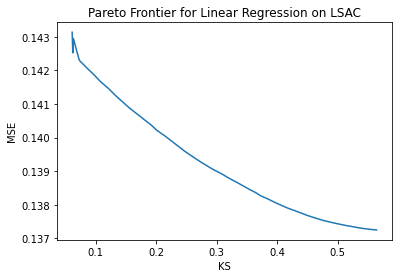

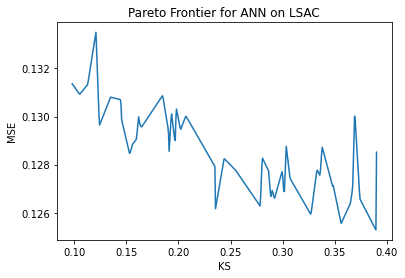

In [41]:
# Pareto frontier plot of linear regression
interploation_model = interp1d(KS_LR, MSE_LR, kind = "linear")

X_LR=np.linspace(KS_LR.min(), KS_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Linear Regression on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier plot of ANN
interploation_model = interp1d(KS_ANN, MSE_ANN, kind = "linear")
 
X_ANN=np.linspace(KS_ANN.min(), KS_ANN.max(), 500)
Y_ANN=interploation_model(X_ANN)
 
plt.plot(X_ANN, Y_ANN)
plt.title("Pareto Frontier for ANN on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()


## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [42]:
MSE_chzhen_list = [0.14059956098698873,
  0.15205907957654569,
  0.14306635635272527,
  0.137330269234612,
  0.14157344270429173]
KS_chzhen_list = [0.06677001400473871,
  0.07102566977171455,
  0.0809844000648367,
  0.10207056286564303,
  0.09354462955438168]
time_chzhen_list = [6271.129221878,
  6865.3056517429995,
  6682.171541546999,
  6639.455036824998,
  6527.266549924003]
MSE_chzhen_list_ANN = [0.12766690849887072,
  0.13626017341342314,
  0.13500187211504142,
  0.12863376158702094,
  0.131659848138675]
KS_chzhen_list_ANN = [0.10858516906978588,
  0.05771306278644443,
  0.05409952434450649,
  0.08615697941417247,
  0.06271163483678721]
time_chzhen_list_ANN = [7593.746866715002,
  7754.263235025006,
  6561.0633790659995,
  6227.002467115002,
  6511.589547302006]

## Generate Figures

In [43]:
# due to the randomness in training ANN, we use the MSE(KS)_origin_list_ANN directly from the MSE(KS)_path_list_ANN to have better visualization
# but one could choose to skip this step and derive similar figures
MSE_origin_list_ANN = np.array(MSE_path_list_ANN)[:,0]
KS_origin_list_ANN = np.array(KS_path_list_ANN)[:,0]
MSE_fair_list_ANN = np.array(MSE_path_list_ANN)[:,49]
KS_fair_list_ANN = np.array(KS_path_list_ANN)[:,49]

# mean and standard deviation of the MSE and KS resulting from the comparison methods:
MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)
MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
MSE_chzhen_std = np.std(MSE_chzhen_list)
KS_origin_mean = np.mean(KS_origin_list)
KS_d_mean = np.mean(KS_d_list)
KS_fair_mean = np.mean(KS_fair_list)
KS_chzhen_mean = np.mean(KS_chzhen_list)
KS_origin_std = np.std(KS_origin_list)
KS_d_std = np.std(KS_d_list)
KS_fair_std = np.std(KS_fair_list)
KS_chzhen_std = np.std(KS_chzhen_list)
MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)
MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)
KS_origin_mean_ANN = np.mean(KS_origin_list_ANN)
KS_d_mean_ANN = np.mean(KS_d_list_ANN)
KS_fair_mean_ANN = np.mean(KS_fair_list_ANN)
KS_chzhen_mean_ANN = np.mean(KS_chzhen_list_ANN)
KS_origin_std_ANN = np.std(KS_origin_list_ANN)
KS_d_std_ANN = np.std(KS_d_list_ANN)
KS_fair_std_ANN = np.std(KS_fair_list_ANN)
KS_chzhen_std_ANN = np.std(KS_chzhen_list_ANN)

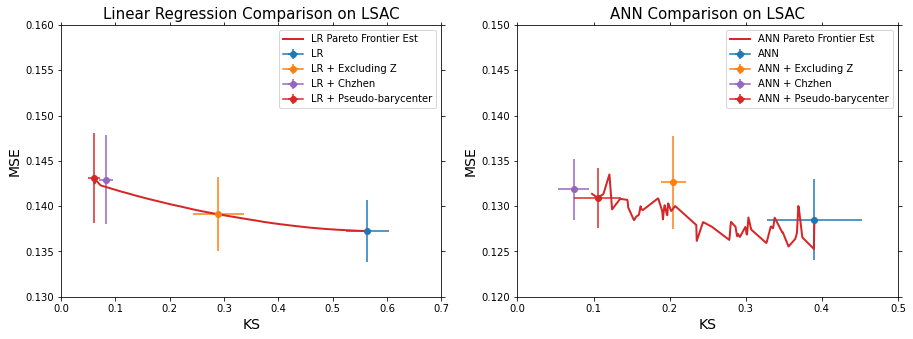

In [44]:
# Generate Figure
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].errorbar(KS_origin_mean, MSE_origin_mean, xerr=KS_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].errorbar(KS_d_mean, MSE_d_mean, xerr=KS_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(KS_chzhen_mean, MSE_chzhen_mean, xerr=KS_chzhen_std, yerr=MSE_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(KS_fair_mean, MSE_fair_mean, xerr=KS_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter
axs[0].plot(X_LR,Y_LR,linewidth = 2, color = '#d62728')

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR Pareto Frontier Est','LR','LR + Excluding Z','LR + Chzhen','LR + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('KS', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on LSAC", fontsize=15)
axs[0].set_ylim(0.13, 0.16)
axs[0].set_xlim(0, 0.7)


axs[1].errorbar(KS_origin_mean_ANN, MSE_origin_mean_ANN, xerr=KS_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].errorbar(KS_d_mean_ANN, MSE_d_mean_ANN, xerr=KS_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(KS_chzhen_mean_ANN, MSE_chzhen_mean_ANN, xerr=KS_chzhen_std_ANN, yerr=MSE_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(KS_fair_mean_ANN, MSE_fair_mean_ANN, xerr=KS_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter
axs[1].plot(X_ANN,Y_ANN,linewidth = 2, color = '#d62728')

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN Pareto Frontier Est','ANN','ANN + Excluding Z','ANN + Chzhen','ANN + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('KS', fontsize=14)
axs[1].set_title(f"ANN Comparison on LSAC", fontsize=15)
axs[1].set_ylim(0.12, 0.15)
axs[1].set_xlim(0, 0.5)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier LSAC', dpi=400,bbox_inches='tight')